In [2]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import keras
from tensorflow.keras.layers import LSTM, Dense

from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping 
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.models import load_model
from sklearn.model_selection import KFold

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
import gc
import pickle

## Create all possible combinations of input variables

In [2]:
from itertools import combinations

# List of strings
strings = ['T', 'HR', 'RADMED', 'VVMED']

# Get all unique combinations of the strings
all_combinations = set()

# Loop over different combination lengths
for r in range(1, len(strings) + 1):
    # Generate combinations of length r
    combinations_r = combinations(strings, r)
    # Add unique combinations to the set
    all_combinations.update(combinations_r)

# Convert the combinations to lists 
all = [list(combination) for combination in all_combinations]

all_combinations = []

# Print all unique combinations
for combination in all:
    comb = []
    for c in combination:
        if c == 'T':
            comb.append('TMAX')
            comb.append('TMIN')
        elif c == 'HR':
            comb.append('HRMAX')
            comb.append('HRMIN')
        else:
            comb.append(c)
    all_combinations.append(comb)
all_combinations

[['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'VVMED'],
 ['RADMED'],
 ['TMAX', 'TMIN', 'RADMED', 'VVMED'],
 ['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED'],
 ['TMAX', 'TMIN', 'RADMED'],
 ['TMAX', 'TMIN', 'HRMAX', 'HRMIN'],
 ['HRMAX', 'HRMIN', 'RADMED', 'VVMED'],
 ['HRMAX', 'HRMIN', 'RADMED'],
 ['TMAX', 'TMIN'],
 ['VVMED'],
 ['RADMED', 'VVMED'],
 ['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED'],
 ['HRMAX', 'HRMIN', 'VVMED'],
 ['TMAX', 'TMIN', 'VVMED'],
 ['HRMAX', 'HRMIN']]

# Train the base model

In [2]:
# Select station to train the models
stationCode = 'CA91'
stationPath = './all data murcia/' + stationCode + '.csv'

In [6]:
def convertirComa(x):
    if type(x) == str:
        return x.replace(",", ".")
    else:
        return x
def leerEstacionDatos(path):
    estacionDatas = pd.read_csv(path, encoding='ISO-8859-1', sep=";")
    estacionDatas.columns = ['ESTACION', 'MUNICIPIO', 'PARAJE', 'HORAS', 'FECHA', 'ETO','TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED','VVMED', '-']
    estacionDatas = estacionDatas.drop(columns=['ESTACION', 'MUNICIPIO', 'PARAJE', 'HORAS', '-'])
    estacionDatas = estacionDatas.reset_index().drop(columns='index')
    estacionDatas['FECHA'] = pd.to_datetime(estacionDatas['FECHA'], format="%d/%m/%y")
    estacionDatas.index = estacionDatas['FECHA']
    estacionDatas.drop(columns='FECHA', inplace=True)
    estacionDatas.dropna(inplace=True)
    for i in estacionDatas.columns:
        estacionDatas[i] = pd.to_numeric(estacionDatas[i].apply(lambda x : convertirComa(x)))
    return estacionDatas
estacionDatas = leerEstacionDatos(stationPath)
estacionDatas

,ETO,TMAX,TMIN,HRMAX,HRMIN,RADMED,VVMED
FECHA,,,,,,,
2010-01-01,1.91,8.88,3.15,80.30,50.12,125.33,5.95
2010-01-02,1.23,12.53,3.22,87.70,44.93,118.40,1.64
2010-01-03,0.99,11.38,0.65,90.40,52.09,84.07,1.34
2010-01-04,0.74,10.93,4.41,94.10,74.00,51.77,1.22
2010-01-05,1.38,11.95,5.89,84.10,57.20,93.29,2.60
...,...,...,...,...,...,...,...
2024-06-21,5.78,27.41,11.60,73.47,26.65,354.14,1.22
2024-06-22,5.84,29.73,12.68,67.41,26.66,328.23,1.27
2024-06-23,6.00,28.43,16.66,81.09,36.02,341.44,1.52


In [58]:
train = estacionDatas[estacionDatas.index < '2020-01-01']
test = estacionDatas[(estacionDatas.index >= '2020-01-01') & (estacionDatas.index <= '2023-06-17')]
display(train)
display(test)

,ETO,TMAX,TMIN,HRMAX,HRMIN,RADMED,VVMED
FECHA,,,,,,,
2010-01-01,1.83,16.60,5.10,80.60,39.80,109.17,2.20
2010-01-02,0.86,19.00,4.40,95.50,39.90,106.13,0.46
2010-01-03,0.84,16.80,4.30,96.30,54.40,89.29,0.60
2010-01-04,0.64,15.40,7.00,95.50,79.00,50.25,0.45
2010-01-05,0.87,17.40,7.80,95.50,53.20,63.21,0.58
...,...,...,...,...,...,...,...
2019-12-27,0.74,17.05,6.27,91.30,60.71,116.96,0.43
2019-12-28,0.74,15.70,4.63,93.13,61.92,123.14,0.54
2019-12-29,0.72,15.33,6.96,91.92,56.11,100.36,0.43


,ETO,TMAX,TMIN,HRMAX,HRMIN,RADMED,VVMED
FECHA,,,,,,,
2020-01-01,0.79,15.45,4.17,92.48,58.49,125.94,0.62
2020-01-02,0.60,12.71,4.77,92.12,66.03,50.90,0.30
2020-01-03,0.71,15.50,2.65,92.93,58.36,122.60,0.44
2020-01-04,0.71,14.30,5.16,91.90,61.63,77.69,0.47
2020-01-05,0.77,15.90,2.78,91.42,44.23,127.98,0.45
...,...,...,...,...,...,...,...
2023-06-13,5.44,29.05,18.07,89.67,37.36,329.76,0.88
2023-06-14,5.94,30.40,17.41,78.34,28.32,350.25,0.99
2023-06-15,6.02,30.34,17.07,84.75,25.45,354.18,1.05


# Iterate all combinations and hyper-parameter tuning

In [12]:

print(stationCode)
# define search space
param_vals = {    
    "first_layer": range(12, 256, 12),
    "second_layer": range(4, 128, 4),
    "dropout": [0, 0.2, 0.4],
    "loss": ["mse", "mae"],
    "optimizer": ["adam", "sgd", "RMSprop"],
    "optimizer__learning_rate": [0.001, 0.01, 0.1],
    "activation": ["relu", "tanh"],
    "batch_size": [32, 64, 128]
    }

def get_model(first_layer, second_layer, dropout, activation, meta):

    model = Sequential() 
    model.add(LSTM(first_layer, activation = activation, input_shape=(1, X_train.shape[2]), return_sequences=True)) 
    model.add(Dropout(dropout))
    model.add(LSTM(second_layer, activation = activation)) 
    model.add(Dense(1))
    return model

scoring_metrics = ['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'r2', 'neg_mean_squared_error']

all_medidas = []
lstmCV5results = []
for comb in all_combinations:

    print(comb)
    # Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scales with whole values
    scaler_X = scaler_X.fit(estacionDatas[comb])
    scaler_y = scaler_y.fit(np.array(estacionDatas['ETO']).reshape(-1,1))

    # Scale inputs X
    X_train = scaler_X.transform(train[comb])
    X_test = scaler_X.transform(test[comb])

    # Scale the output y
    y_train = scaler_y.transform(np.array(train['ETO']).reshape(-1, 1))
    y_test = scaler_y.transform(np.array(test['ETO']).reshape(-1, 1))
    
    # Reshape each set
    X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
    y_train = np.array(y_train).reshape(y_train.shape[0], 1)
    y_test = np.array(y_test).reshape(y_test.shape[0], 1)
   
    modelLSTM = KerasRegressor(
        get_model,
        metrics = ['mean_absolute_error'],
        loss=None,
        first_layer = None,
        second_layer= None,
        dropout = None,
        activation=None,
        batch_size=None, 
        optimizer=None,
        epochs = 500, 
        verbose = 0, 
        validation_split = 0.2, 
        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 30)],
        random_state=123
    )

    # define the search
    searchLSTM = RandomizedSearchCV(estimator=modelLSTM, param_distributions=param_vals, 
                                    n_jobs=-1, cv=5, verbose=3, n_iter=60,
                                    scoring=scoring_metrics, refit='neg_mean_absolute_error', random_state=123)
    
    # perform the search
    searchLSTM.fit(X_train, y_train)

    # Make predictions from X_test datas
    y_pred = searchLSTM.best_estimator_.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred).flatten()

    lstmCV5results.append(pd.DataFrame(searchLSTM.cv_results_).iloc[searchLSTM.best_index_])

    medidas = []

    medidas.append(str(comb))
    medidas.append(str(searchLSTM.best_estimator_))
    medidas.append(searchLSTM.best_score_)
    medidas.append(np.corrcoef(test['ETO'], y_pred)[0][1]**2)
    medidas.append(mean_absolute_error(y_true=test['ETO'],y_pred=y_pred))
    medidas.append(mean_absolute_percentage_error(y_true=test['ETO'],y_pred=y_pred)*100)
    medidas.append(mean_squared_error(y_true=test['ETO'],y_pred=y_pred,squared=False))

    all_medidas.append(medidas)

all_medidas_lstm = pd.DataFrame(all_medidas, columns=['combination', 'hyperparameters', 'mean_train_mae', 'test_R2', 'test_MAE', 'test_MAPE', 'test_RMSE'])
all_medidas_lstm

CR12
['TMAX', 'TMIN', 'HRMAX', 'HRMIN']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['RADMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['HRMAX', 'HRMIN', 'RADMED', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['HRMAX', 'HRMIN']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['RADMED', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['HRMAX', 'HRMIN', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'RADMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['HRMAX', 'HRMIN', 'RADMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['TMAX', 'TMIN', 'RADMED', 'VVMED']
Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\psyey\Documents\notebooks\notebooks\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,combination,hyperparameters,mean_train_mae,test_R2,test_MAE,test_MAPE,test_RMSE
0,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN']",KerasRegressor(\n\tmodel=<function get_model a...,-0.298446,0.826041,0.645297,27.525072,0.841474
1,['VVMED'],KerasRegressor(\n\tmodel=<function get_model a...,-0.817554,0.011620,1.537130,63.101442,1.884056
2,['RADMED'],KerasRegressor(\n\tmodel=<function get_model a...,-0.293157,0.859753,0.550868,22.835135,0.716446
3,"['HRMAX', 'HRMIN', 'RADMED', 'VVMED']",KerasRegressor(\n\tmodel=<function get_model a...,-0.233184,0.904292,0.401760,15.893954,0.529927
4,"['TMAX', 'TMIN']",KerasRegressor(\n\tmodel=<function get_model a...,-0.379744,0.797169,0.652299,27.748031,0.841342
5,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', '...",KerasRegressor(\n\tmodel=<function get_model a...,-0.066441,0.991004,0.118848,5.419723,0.166013
6,"['HRMAX', 'HRMIN']",KerasRegressor(\n\tmodel=<function get_model a...,-0.548910,0.477778,1.093714,50.076921,1.435627
7,"['RADMED', 'VVMED']",KerasRegressor(\n\tmodel=<function get_model a...,-0.278563,0.869981,0.471374,19.116468,0.634951
8,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'VVMED']",KerasRegressor(\n\tmodel=<function get_model a...,-0.244594,0.855265,0.511087,18.416629,0.673762
9,"['TMAX', 'TMIN', 'VVMED']",KerasRegressor(\n\tmodel=<function get_model a...,-0.275132,0.847470,0.524314,19.823918,0.686883


In [13]:
lstmCV5results = pd.DataFrame(lstmCV5results)
lstmCV5results['Combination'] = all_medidas_lstm['combination'].values
lstmCV5results = lstmCV5results.reset_index().drop(columns=['index', 'params'])
lstmCV5results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_second_layer,param_optimizer__learning_rate,param_optimizer,param_loss,param_first_layer,param_dropout,...,rank_test_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,Combination
0,48.380177,13.161916,2.158809,0.575699,44,0.001,RMSprop,mse,60,0.0,...,1,-0.129710,-0.134539,-0.145191,-0.152892,-0.170598,-0.146586,0.014479,1,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN']"
1,56.416358,13.473765,2.601390,0.982119,80,0.001,adam,mse,228,0.0,...,2,-0.859797,-1.030557,-0.825783,-1.042670,-1.053102,-0.962382,0.098496,1,['VVMED']
2,35.156579,15.361629,1.094605,0.174744,52,0.010,RMSprop,mae,12,0.0,...,1,-0.126114,-0.254791,-0.150448,-0.137818,-0.106744,-0.155183,0.051840,1,['RADMED']
3,74.458316,38.473209,2.860457,1.227446,44,0.001,RMSprop,mse,60,0.0,...,2,-0.082123,-0.127290,-0.101453,-0.090529,-0.079465,-0.096172,0.017347,1,"['HRMAX', 'HRMIN', 'RADMED', 'VVMED']"
4,83.730132,8.237681,2.926369,0.755994,44,0.001,adam,mae,96,0.0,...,9,-0.174125,-0.268411,-0.253190,-0.232563,-0.226126,-0.230883,0.032103,12,"['TMAX', 'TMIN']"
5,65.388991,16.231810,2.548047,1.197673,44,0.001,adam,mae,96,0.0,...,4,-0.009217,-0.007751,-0.009188,-0.007034,-0.009063,-0.008451,0.000895,4,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', '..."
6,73.850257,26.497268,1.174874,0.534356,72,0.001,RMSprop,mae,12,0.2,...,23,-0.508385,-0.516610,-0.456208,-0.496635,-0.529722,-0.501512,0.025089,23,"['HRMAX', 'HRMIN']"
7,41.551811,6.693067,1.975655,0.253282,124,0.001,RMSprop,mae,24,0.2,...,9,-0.119127,-0.230756,-0.138393,-0.130867,-0.102988,-0.144426,0.044789,9,"['RADMED', 'VVMED']"
8,295.898156,71.965357,2.264967,0.835304,120,0.010,sgd,mae,132,0.2,...,5,-0.091003,-0.110963,-0.092473,-0.106818,-0.125667,-0.105385,0.012791,5,"['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'VVMED']"
9,49.235102,6.050432,2.538192,0.455445,100,0.001,RMSprop,mse,36,0.4,...,2,-0.092715,-0.140304,-0.103883,-0.132006,-0.149802,-0.123742,0.021812,1,"['TMAX', 'TMIN', 'VVMED']"


In [14]:
stationCode

'CR12'

In [15]:
lstmCV5results.to_excel('./lstm'+stationCode+'.xlsx', index=False)
all_medidas_lstm.to_excel('./all_medidas'+stationCode+'.xlsx', index=False)

# Train final models

## Check the test set metrics

In [59]:
from sklearn.preprocessing import StandardScaler


def checkFinalModelsOnValidationSet(comb, loss, first_layer, second_layer, dropout, activation, batch_size, optimizer):

    print(comb)

    # Scalers
    #scaler_X = MinMaxScaler(feature_range=(0, 1))
    #scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scales with whole values
    scaler_X = scaler_X.fit(estacionDatas[comb])
    scaler_y = scaler_y.fit(np.array(estacionDatas['ETO']).reshape(-1,1))

    # Scale inputs X
    X_train = scaler_X.transform(train[comb])
    X_test = scaler_X.transform(test[comb])

    # Scale the output y
    y_train = scaler_y.transform(np.array(train['ETO']).reshape(-1, 1))
    y_test = scaler_y.transform(np.array(test['ETO']).reshape(-1, 1))

    # Reshape each set
    X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
    y_train = np.array(y_train).reshape(y_train.shape[0], 1)
    y_test = np.array(y_test).reshape(y_test.shape[0], 1)

    # Create the model
    random.seed(123)
    np.random.seed(123)
    tf.random.set_seed(123)


    model = Sequential() 
    model.add(LSTM(first_layer, activation = activation, input_shape=(1, X_train.shape[2]), return_sequences=True)) 
    model.add(Dropout(dropout))
    model.add(LSTM(second_layer, activation = activation)) 
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)

    model.summary()

    # Fit the model
    model.fit(X_train, y_train, epochs=500, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor = 'val_loss', patience = 30)])

    # Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions).flatten()

    print("R2:",np.corrcoef(test['ETO'], predictions)[0][1]**2)
    print("RMSE:",mean_squared_error(y_pred=predictions, y_true=test['ETO'], squared=False))
    print("MAE:",mean_absolute_error(y_pred=predictions, y_true=test['ETO']))
    print("MAPE:",mean_absolute_percentage_error(y_pred=predictions, y_true=test['ETO'])*100)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test.index, y=test['ETO'],
                                name='real', mode='lines'))
    fig.add_trace(go.Scatter(x=test.index, y=predictions,
                                name='pred', mode='lines'))
    fig.show()

    return model, [scaler_X, scaler_y]

In [60]:
# Define the best combination of each number of variables
param4 = ['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED']
param3 = ['TMAX', 'TMIN', 'RADMED', 'VVMED']
param2 = ['TMAX', 'TMIN', 'RADMED']
param1 = ['RADMED']

all_params = [param4, param3, param2, param1]
if stationCode == 'CR12':
    losses = ['mae', 'mse', 'mae', 'mae'] 
    first_layers = [96, 180, 228, 12] 
    second_layers = [44, 124, 124, 52] 
    dropouts = [0, 0, 0, 0]
    activations = ['relu', 'relu', 'relu', 'relu'] 
    batch_sizes = [32, 32, 64, 64]
    optimizers = [Adam(0.001), RMSprop(0.001), Adam(0.001), RMSprop(0.01)]
    
elif stationCode == 'CA91':
    losses = ['mae', 'mae', 'mae', 'mae'] 
    first_layers = [96, 228, 96, 156] 
    second_layers = [44, 124, 124, 20] 
    dropouts = [0, 0, 0, 0.2]
    activations = ['relu', 'relu', 'relu', 'relu'] 
    batch_sizes = [32, 64, 128, 128]
    optimizers = [Adam(0.001), Adam(0.001), Adam(0.01), Adam(0.1)]

elif stationCode == 'CI42':
    losses = ['mae', 'mae', 'mae', 'mae'] 
    first_layers = [228, 96, 24, 108] 
    second_layers = [124, 44, 100, 116] 
    dropouts = [0, 0, 0, 0.2]
    activations = ['relu', 'relu', 'relu', 'tanh'] 
    batch_sizes = [64, 32, 128, 128]
    optimizers = [Adam(0.001), Adam(0.001), Adam(0.01), RMSprop(0.01)]

final_models = []
all_scalers = []
for idx, param in enumerate(all_params):
    model, scalers = checkFinalModelsOnValidationSet(param, losses[idx], first_layers[idx], second_layers[idx], dropouts[idx], activations[idx], batch_sizes[idx], optimizers[idx])
    final_models.append(model)
    all_scalers.append(scalers)

final_models


['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 96)             39552     
                                                                 
 dropout (Dropout)           (None, 1, 96)             0         
                                                                 
 lstm_1 (LSTM)               (None, 44)                24816     
                                                                 
 dense (Dense)               (None, 1)                 45        
                                                                 
Total params: 64413 (251.61 KB)
Trainable params: 64413 (251.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
39/39 [==============================] - 0s 1ms/step
R2: 0.9866171459934175
RMSE: 0.217555039635

['TMAX', 'TMIN', 'RADMED', 'VVMED']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 228)            212496    
                                                                 
 dropout_1 (Dropout)         (None, 1, 228)            0         
                                                                 
 lstm_3 (LSTM)               (None, 124)               175088    
                                                                 
 dense_1 (Dense)             (None, 1)                 125       
                                                                 
Total params: 387709 (1.48 MB)
Trainable params: 387709 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
39/39 [==============================] - 0s 1ms/step
R2: 0.9851087689819807
RMSE: 0.2249733937652877
MAE: 0.149044

['TMAX', 'TMIN', 'RADMED']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 96)             38400     
                                                                 
 dropout_2 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_5 (LSTM)               (None, 124)               109616    
                                                                 
 dense_2 (Dense)             (None, 1)                 125       
                                                                 
Total params: 148141 (578.68 KB)
Trainable params: 148141 (578.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
39/39 [==============================] - 0s 1ms/step
R2: 0.9718087098985392
RMSE: 0.2921762025167959
MAE: 0.20789019335

['RADMED']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 156)            98592     
                                                                 
 dropout_3 (Dropout)         (None, 1, 156)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                14160     
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 112773 (440.52 KB)
Trainable params: 112773 (440.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
39/39 [==============================] - 0s 1ms/step
R2: 0.906338305208093
RMSE: 0.5731241442567508
MAE: 0.45164607663609285
MAPE: 17.5

## Train the final models

In [4]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

def trainFinalModel(comb, loss, first_layer, second_layer, dropout, activation, batch_size, optimizer):

    print(comb)

    # Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scales with whole values
    scaler_X = scaler_X.fit(estacionDatas[comb])
    scaler_y = scaler_y.fit(np.array(estacionDatas['ETO']).reshape(-1,1))

    # Scale inputs X
    input = scaler_X.transform(estacionDatas[comb])

    # Scale the output y
    output = scaler_y.transform(np.array(estacionDatas['ETO']).reshape(-1, 1))

    # Reshape each set
    input = np.array(input).reshape(input.shape[0], 1, input.shape[1])
    output = np.array(output).reshape(output.shape[0], 1, output.shape[1])

    # Create the model
    random.seed(123)
    np.random.seed(123)
    tf.random.set_seed(123)


    model = Sequential() 
    model.add(LSTM(first_layer, activation = activation, input_shape=(1, input.shape[2]), return_sequences=True)) 
    model.add(Dropout(dropout))
    model.add(LSTM(second_layer, activation = activation)) 
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)

    model.summary()

    # Fit the model
    history = model.fit(input, output, epochs=500, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor = 'val_loss', patience = 30)])
	# plot loss during training
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    return model, [scaler_X, scaler_y]

['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 96)             39552     
                                                                 
 dropout (Dropout)           (None, 1, 96)             0         
                                                                 
 lstm_1 (LSTM)               (None, 44)                24816     
                                                                 
 dense (Dense)               (None, 1)                 45        
                                                                 
Total params: 64413 (251.61 KB)
Trainable params: 64413 (251.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


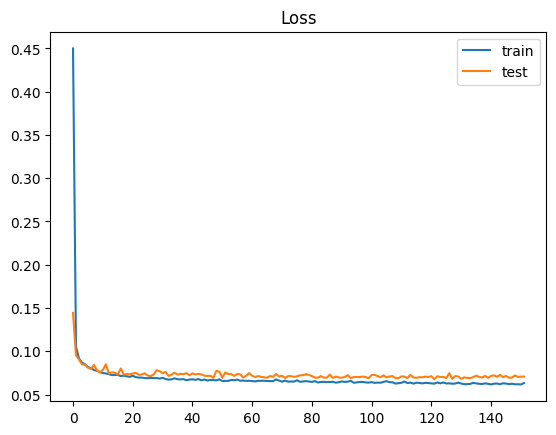

['TMAX', 'TMIN', 'RADMED', 'VVMED']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 228)            212496    
                                                                 
 dropout_1 (Dropout)         (None, 1, 228)            0         
                                                                 
 lstm_3 (LSTM)               (None, 124)               175088    
                                                                 
 dense_1 (Dense)             (None, 1)                 125       
                                                                 
Total params: 387709 (1.48 MB)
Trainable params: 387709 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


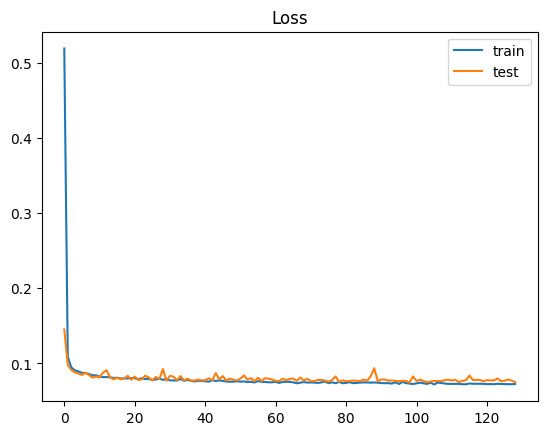

['TMAX', 'TMIN', 'RADMED']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 96)             38400     
                                                                 
 dropout_2 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_5 (LSTM)               (None, 124)               109616    
                                                                 
 dense_2 (Dense)             (None, 1)                 125       
                                                                 
Total params: 148141 (578.68 KB)
Trainable params: 148141 (578.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


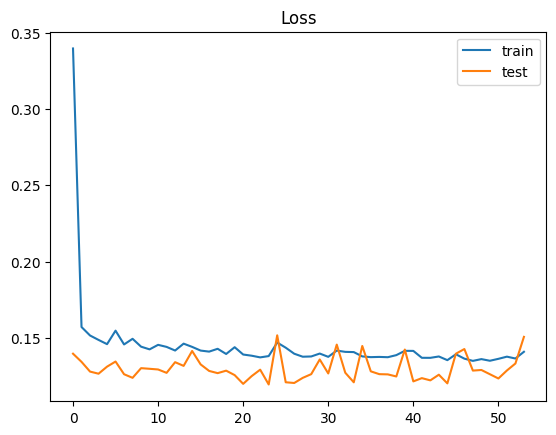

['RADMED']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 156)            98592     
                                                                 
 dropout_3 (Dropout)         (None, 1, 156)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                14160     
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 112773 (440.52 KB)
Trainable params: 112773 (440.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


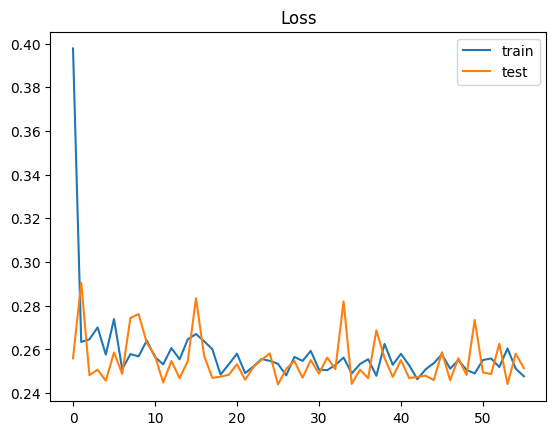

In [5]:
# Define the best combination of each number of variables
param4 = ['TMAX', 'TMIN', 'HRMAX', 'HRMIN', 'RADMED', 'VVMED']
param3 = ['TMAX', 'TMIN', 'RADMED', 'VVMED']
param2 = ['TMAX', 'TMIN', 'RADMED']
param1 = ['RADMED']

all_params = [param4, param3, param2, param1]
if stationCode == 'CR12':
    losses = ['mae', 'mse', 'mae', 'mae'] 
    first_layers = [96, 180, 228, 12] 
    second_layers = [44, 124, 124, 52] 
    dropouts = [0, 0, 0, 0]
    activations = ['relu', 'relu', 'relu', 'relu'] 
    batch_sizes = [32, 32, 64, 64]
    optimizers = [Adam(0.001), RMSprop(0.001), Adam(0.001), RMSprop(0.01)]
    
elif stationCode == 'CA91':
    losses = ['mae', 'mae', 'mae', 'mae'] 
    first_layers = [96, 228, 96, 156] 
    second_layers = [44, 124, 124, 20] 
    dropouts = [0, 0, 0, 0.2]
    activations = ['relu', 'relu', 'relu', 'relu'] 
    batch_sizes = [32, 64, 128, 128]
    optimizers = [Adam(0.001), Adam(0.001), Adam(0.01), Adam(0.1)]

elif stationCode == 'CI42':
    losses = ['mae', 'mae', 'mae', 'mae'] 
    first_layers = [228, 96, 24, 108] 
    second_layers = [124, 44, 100, 116] 
    dropouts = [0, 0, 0, 0.2]
    activations = ['relu', 'relu', 'relu', 'tanh'] 
    batch_sizes = [64, 32, 128, 128]
    optimizers = [Adam(0.001), Adam(0.001), Adam(0.01), RMSprop(0.01)]

final_models = []
all_scalers = []
for idx, param in enumerate(all_params):
    model, scalers = trainFinalModel(param, losses[idx], first_layers[idx], second_layers[idx], dropouts[idx], activations[idx], batch_sizes[idx], optimizers[idx])
    final_models.append(model)
    all_scalers.append(scalers)

final_models


In [6]:
# Save scalers and models
with open('all_scalers'+stationCode+'.pkl', 'wb') as file:
    pickle.dump(all_scalers, file)

final_models[0].save('./'+stationCode+'M4.keras')
final_models[1].save('./'+stationCode+'M3.keras')
final_models[2].save('./'+stationCode+'M2.keras')
final_models[3].save('./'+stationCode+'M1.keras')